<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/mr0_bSSFP_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pypulseq &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground/quantified_brain.npz &> /dev/null

# Imports and definitions

In [3]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [31]:
#@title Define SSFP in PyPulseq
# %% S2. DEFINE the sequence

FAex =60  #@param {type: "slider", min: 1, max: 180}
P_alpha_half= True #@param {type: "boolean"}
TR_ms =  0 #@param {type: "slider", min: 0.0, max: 20, step:0.1}
TR=TR_ms*1e-3
PEtype='linear'  #@param ['centric', 'linear']
PE_flag= True #@param {type: "boolean"}
TI =  0 #@param {type: "slider", min: 0, max: 5, step:0.1}

# choose the scanner limits
system = pp.Opts(max_grad=40,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=10e-6)
Nread = 64
Nphase= 64

seq = pp.Sequence(system)

# Define FOV and resolution
fov = 200e-3
slice_thickness = 8e-3

# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

fastest_grad = pp.make_extended_trapezoid_area(area=(Nphase)/fov, channel='y', grad_end=0.0, grad_start=0.0, system=system)
min_gr_dur=fastest_grad[0].shape_dur  # this is a first speedup test, in shoudl run with area=(Nphase/2)/fov, but only area=(Nphase)/fov worked

dwell=3e-05

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=dwell*Nread, system=system)
adc = pp.make_adc(num_samples=Nread, duration=dwell*Nread, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=min_gr_dur, system=system)
gp = pp.make_trapezoid(channel='y', area=1, duration=min_gr_dur, system=system)

rf_phase = 0

# Define rf events
rf_IR= pp.make_block_pulse(
    flip_angle=  180* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3, system=system)
gz_spoil = pp.make_trapezoid(channel='z',area=64, duration=1e-3, system=system)

rfdur=0.8e-3
rf1, gz1, gzr1 = pp.make_sinc_pulse(
  flip_angle=FAex * np.pi / 180, duration=rfdur,
  slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
  system=system, return_gz=True)

rf0, gz0, gzr0 = pp.make_sinc_pulse(
  flip_angle=FAex/2* np.pi / 180, duration=rfdur,
  slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
  system=system, return_gz=True)

# ======
# CONSTRUCT SEQUENCE
# ======
##linear reordering
phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
permvec =np.arange(0, Nphase, 1)
## centric reordering
if PEtype=='centric':
  permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
## random reordering
#perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

phenc_centr = phenc[permvec] *PE_flag

ktraj=np.array([])
if TI>0:
  seq.add_block(rf_IR)
  seq.add_block(gz_spoil)
  seq.add_block(pp.make_delay(TI))

seq.add_block(pp.make_delay(0.0015-(rfdur/2+rf1.delay)))

minTR=pp.calc_duration(gz1) + pp.calc_duration(gx_pre,gp,gzr1)+pp.calc_duration(gx)+pp.calc_duration(gp,gx_pre,gzr1)
minTR2=minTR/2
TRd=round(max(0, (TR/2-minTR2))/10e-5)*10e-5  # round to raster time
TR=2*(minTR2 +TRd)
if TRd==0:
  print('rep. time set to minTR [ms]',TR*1000)
else:
  print(' TR [ms]', TR*1000)

if P_alpha_half:
  seq.add_block(rf0,gz0)
  seq.add_block(gzr0)
  # last timing step is to add TR/2 between alpha half and first rf pulse
  # from pulse top to pulse top we have already played out one full gz0 and 2*gzr0, thus we substract these from TR
  seq.add_block(pp.make_delay(minTR2+TRd-pp.calc_duration(gz0)-2*pp.calc_duration(gzr0)))   #  for balancing Gz is played out twice!
  seq.add_block(gzr0)  #  balance Gz!
for ii in range(0, Nphase):  # e.g. -64:63

    rf_phase = divmod(rf_phase + 180, 360.0)[1]
    rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase, 180° alternating phase cycling
    adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC

    ktraj=np.append(ktraj,phenc_centr[ii])
    seq.add_block(rf1,gz1)
    gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=min_gr_dur, system=system)
    seq.add_block(pp.make_delay(TRd))

    seq.add_block(gx_pre, gp,gzr1)
    seq.add_block(adc, gx)
    gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=min_gr_dur, system=system)
    seq.add_block(gx_pre, gp,gzr1)  #  balance Gz!
    seq.add_block(pp.make_delay(TRd))
    # full pulse            delay of rf2 -ringdown rf1  + TR_delay + RO/2
#%% S3. CHECK, PLOT and WRITE the sequence  as .seq
#Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
   print('Timing check passed successfully')
else:
   print('Timing check failed. Error listing follows:')
   [print(e) for e in error_report]

# PLOT sequence
#sp_adc, t_adc = mr0.util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.write('external.seq')


rep. time set to minTR [ms] 3.9
Timing check passed successfully


'88973caf693cdc81917a154f2e022e86'

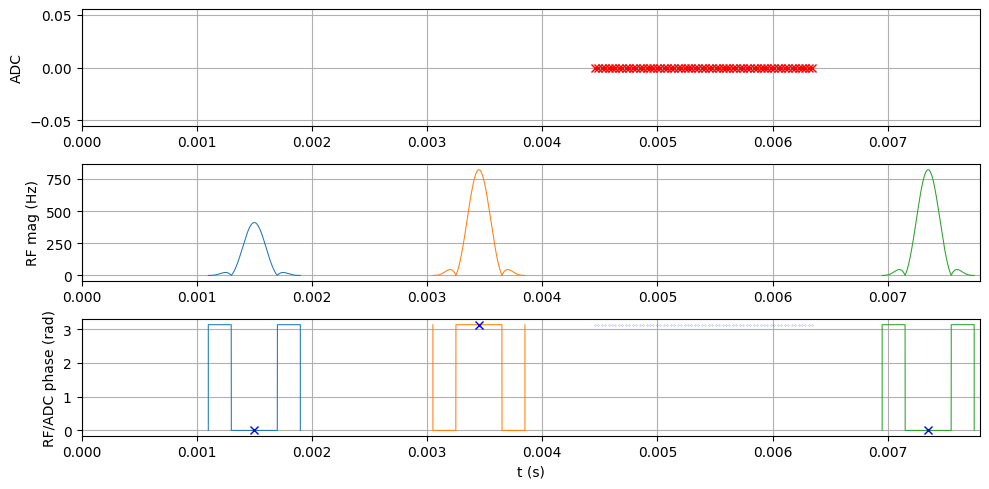

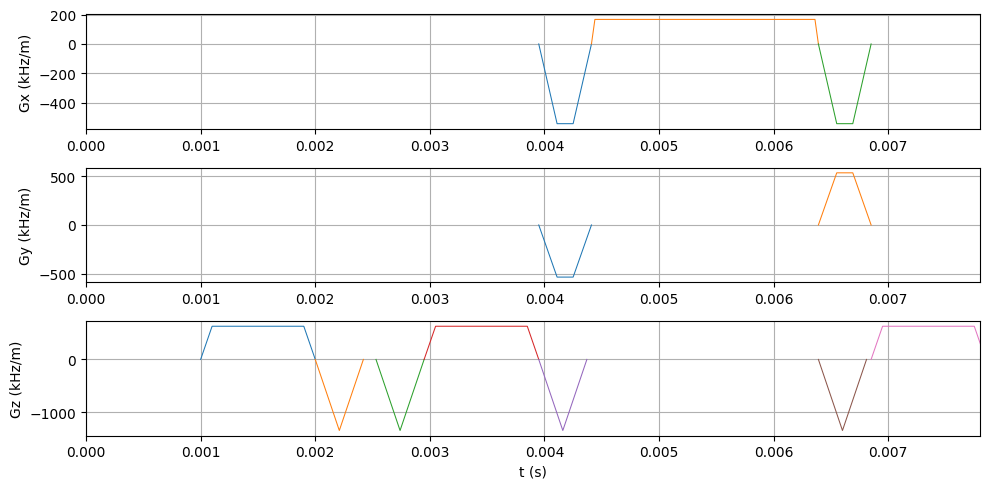

In [32]:
seq.plot(time_range=(0,2*TR))

# RUNs

Calculating repetition 65 / 65 - done


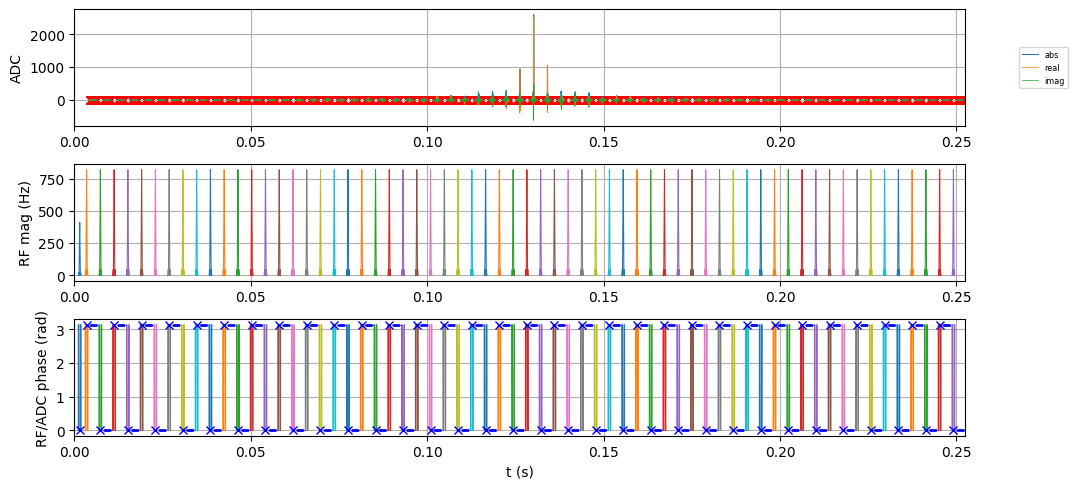

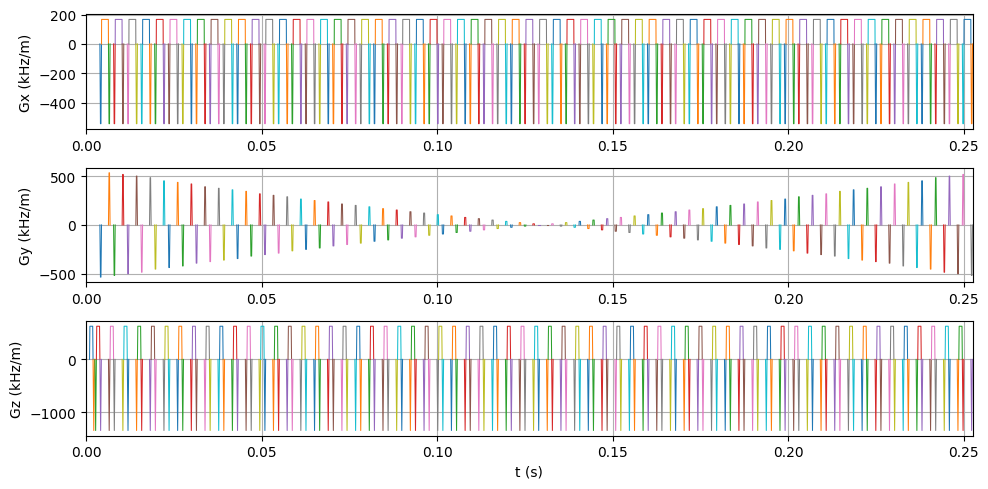

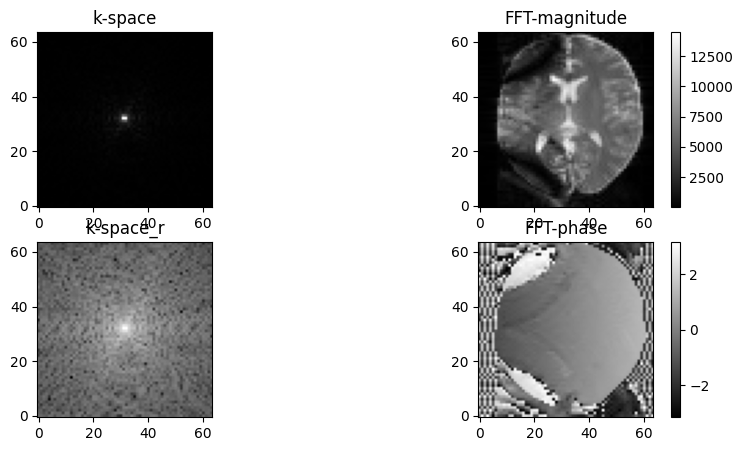

In [33]:
#@title S3 quick 2D brain phantom sim and plot
#signal = mr0.util.simulate_2d(seq)
signal   = mr0.util.simulate_2d(seq,B0_scale=2, B0_polynomial=(0,0,-150,0,0,300))
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'bssfp_seq_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
permvec=np.argsort(ktraj)
kspace=kspace_adc[:,permvec]
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221),plt.gray()
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()



In [22]:
import time


acc_array = [0.6, 0.5, 0.4, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.00001]
dt= np.zeros(len(acc_array))

space_3d = np.zeros((len(acc_array), Nread, Nphase), dtype=np.complex128)  # Adjust dimensions if needed

for i, acc in enumerate(acc_array):
    t0 = time.time()
    signal = ,simulate_brain_2D(seq_fn, verbose=False, accuracy=acc, B0_scale=2, B0_polynomial=(0,0,-150,0,0,300))
    t1 = time.time()
    dt[i]= t1 - t0

    kspace, space = recon(signal, ktraj, Nread, Nphase, verbose=False)
    space_3d[i] = space.numpy()  # Assuming 'space' is a PyTorch tensor
    print(f"Iteration {i + 1} with accuracy {acc:.6f} completed.")

print("All iterations finished. Data stored in 'space_3d'.")

plt.show()

NameError: name 'simulate_brain_2D' is not defined

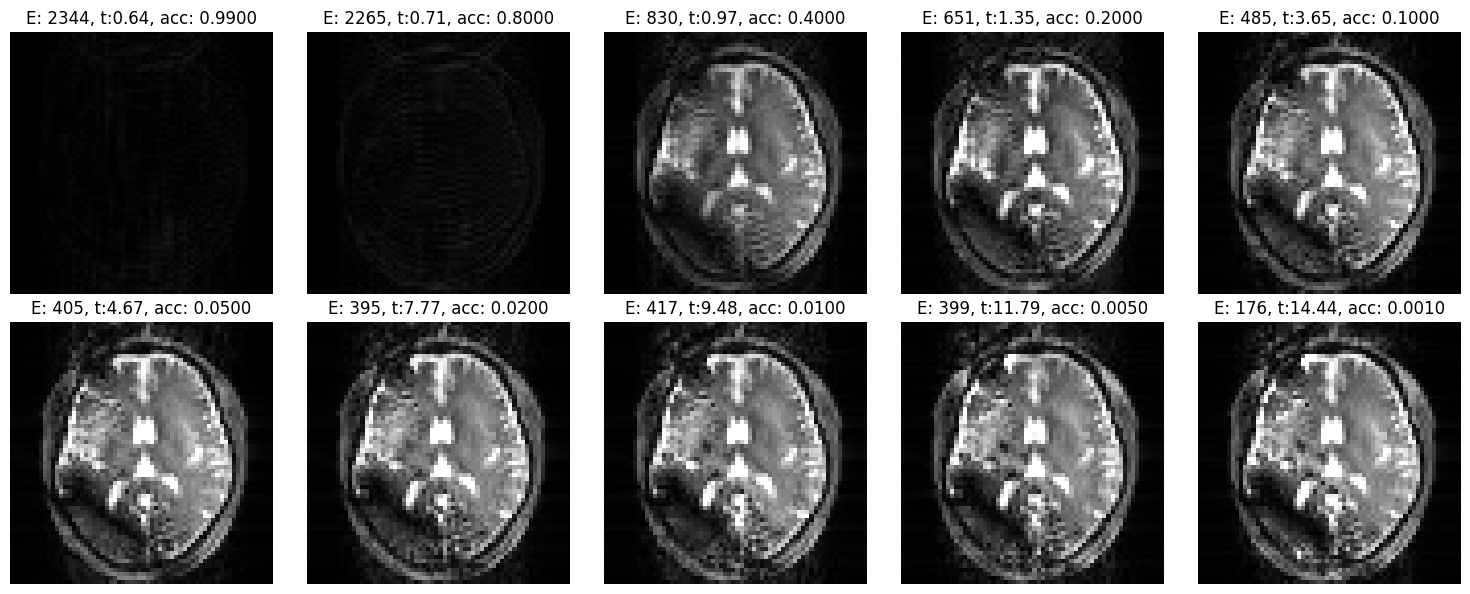

In [ ]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 images
axes = axes.flatten()  # Flatten to a 1D array for easy iteration

# Assuming 'space_3d' is your 3D array of complex images
reference_image = np.abs(space_3d[-1])  # Last image as reference

for i, ax in enumerate(axes):
    image = np.abs(space_3d[i])  # Absolute value of the current image
    rmse = np.sqrt(np.mean((image - reference_image)**2))  # Calculate RMSE
    ax.imshow(image.T, origin="lower",cmap='gray',clim=(0, 6000))
    ax.set_title(f"E: {rmse:.0f}, t:{dt[i]:.2f}, acc: {acc_array[i]:.4f}")
    ax.axis('off')


plt.tight_layout()
